In [14]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [15]:
# Load DNS and HTTP traffic data
dns_df = pd.read_csv('dns_traffic4.csv')
http_df = pd.read_csv('http_traffic4.csv')

In [16]:
# Convert 'Time' columns to datetime
dns_df['Time'] = pd.to_datetime(dns_df['Time'])
http_df['Time'] = pd.to_datetime(http_df['Time'])

In [17]:
# Identify relevant DNS traffic based on HTTP destinations
relevant_destinations = http_df['Destination'].unique()
dns_df = dns_df[dns_df['Destination'].isin(relevant_destinations)]

In [18]:
# Separate DNS queries and responses
dns_queries = dns_df[dns_df['Info'].str.contains("Standard query", case=False)]
dns_responses = dns_df[dns_df['Info'].str.contains("Standard query response", case=False)]

In [19]:
# Rename columns for clarity
dns_queries = dns_queries.rename(columns={'Time': 'Time_query'})
dns_responses = dns_responses.rename(columns={'Time': 'Time_response'})

In [20]:
# Pair DNS queries with responses based on Source, Destination, and Time proximity
dns_pairs = pd.merge_asof(
    dns_queries.sort_values('Time_query'), 
    dns_responses.sort_values('Time_response'), 
    left_on='Time_query', 
    right_on='Time_response', 
    by=['Source', 'Destination'],
    suffixes=('_query', '_response'),
    direction='forward'
)

# Calculate DNS resolution time
dns_pairs['Time_query'] = pd.to_datetime(dns_pairs['Time_query'])
dns_pairs['Time_response'] = pd.to_datetime(dns_pairs['Time_response'])
dns_pairs['resolution_time'] = (dns_pairs['Time_response'] - dns_pairs['Time_query']).dt.total_seconds()

In [21]:
# Filter HTTP requests
http_requests = http_df[http_df['Protocol'] == 'HTTP'].copy()

# Original DNS-HTTP dependency calculation (no caching)
dependencies = []

In [22]:
for _, http_row in http_requests.iterrows():
    destination = http_row['Destination']
    
    # Find the latest DNS response for the destination prior to the HTTP request time
    dns_response = dns_pairs[(dns_pairs['Destination'] == destination) & 
                             (dns_pairs['Time_response'] < http_row['Time'])].tail(1)
    
    if not dns_response.empty:
        dependency_time = (http_row['Time'] - dns_response['Time_response'].values[0]).total_seconds()
    else:
        dependency_time = None  # No matching DNS response found
    
    dependencies.append(dependency_time)

# Store the original dependencies in the DataFrame
http_requests['dns_http_dependency'] = dependencies

In [23]:
# Optimization: Implement DNS Caching
cache_duration = timedelta(seconds=300)  # Adjust cache duration as needed
cached_dns = {}
cached_dependencies = []

In [24]:
for _, http_row in http_requests.iterrows():
    destination = http_row['Destination']
    
    # Check if the destination is in the cache and if it's still valid
    if destination in cached_dns and (http_row['Time'] - cached_dns[destination]['Time_response']) <= cache_duration:
        dependency_time = (http_row['Time'] - cached_dns[destination]['Time_response']).total_seconds()
    else:
        # Find the latest DNS response for the destination prior to the HTTP request time
        dns_response = dns_pairs[(dns_pairs['Destination'] == destination) & 
                                 (dns_pairs['Time_response'] < http_row['Time'])].tail(1)
        
        if not dns_response.empty:
            dependency_time = (http_row['Time'] - dns_response['Time_response'].values[0]).total_seconds()
            # Update cache with this DNS response
            cached_dns[destination] = dns_response.iloc[0]
        else:
            dependency_time = None  # No matching DNS response found
    
    cached_dependencies.append(dependency_time)

# Store optimized dependencies in a new column
http_requests['dns_http_dependency_cached'] = cached_dependencies

### **Visualization**

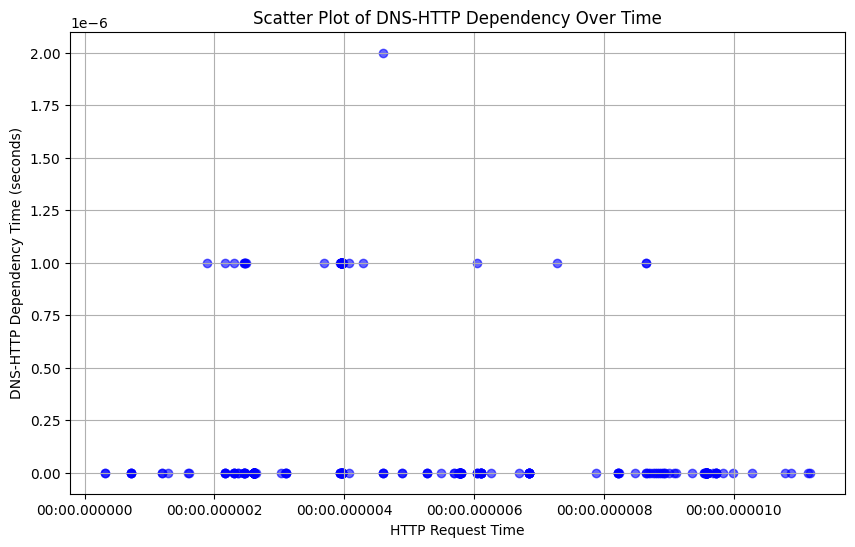

In [25]:
# Visualization 1: Scatter Plot of DNS-HTTP Dependency Times
plt.figure(figsize=(10, 6))
plt.scatter(http_requests['Time'], http_requests['dns_http_dependency'], alpha=0.6, color='blue')
plt.xlabel('HTTP Request Time')
plt.ylabel('DNS-HTTP Dependency Time (seconds)')
plt.title('Scatter Plot of DNS-HTTP Dependency Over Time')
plt.grid()
plt.show()

***Scatter Plot of DNS-HTTP Dependency Over Time***
* This plot shows the time gap (dependency) between DNS resolution completion and the associated HTTP request time, allowing you to observe dependency trends over time.

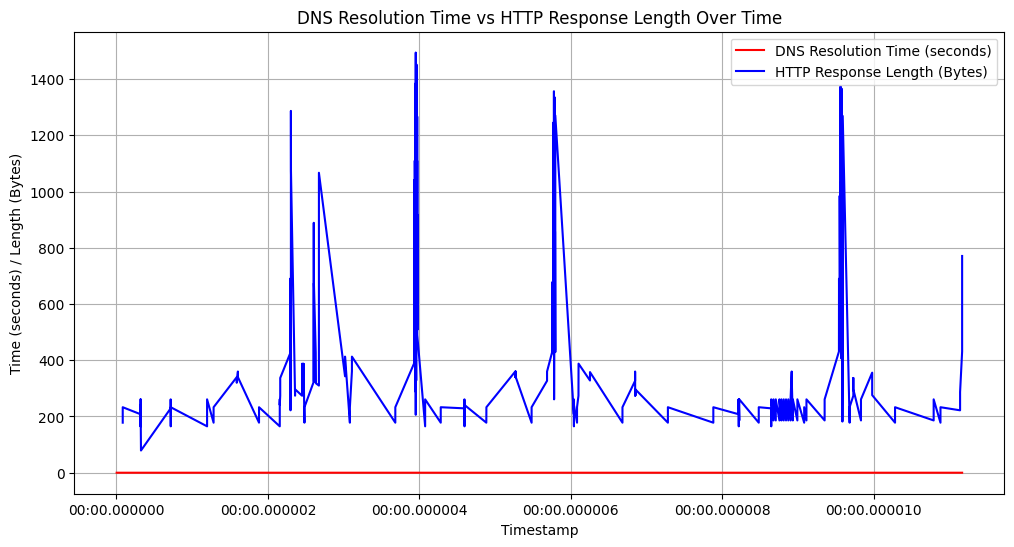

In [26]:
# Visualization 2: Line Plot of DNS Resolution Times and HTTP Response Length
plt.figure(figsize=(12, 6))
plt.plot(dns_pairs['Time_query'], dns_pairs['resolution_time'], label='DNS Resolution Time (seconds)', color='red')
plt.plot(http_df['Time'], http_df['Length'], label='HTTP Response Length (Bytes)', color='blue')
plt.xlabel("Timestamp")
plt.ylabel("Time (seconds) / Length (Bytes)")
plt.legend()
plt.title("DNS Resolution Time vs HTTP Response Length Over Time")
plt.grid()
plt.show()

***Line Plot of DNS Resolution Times and HTTP Response Length Over Time:***
* This plot visualizes DNS resolution time alongside HTTP response lengths to help identify any relationship between DNS delays and HTTP response size fluctuations.

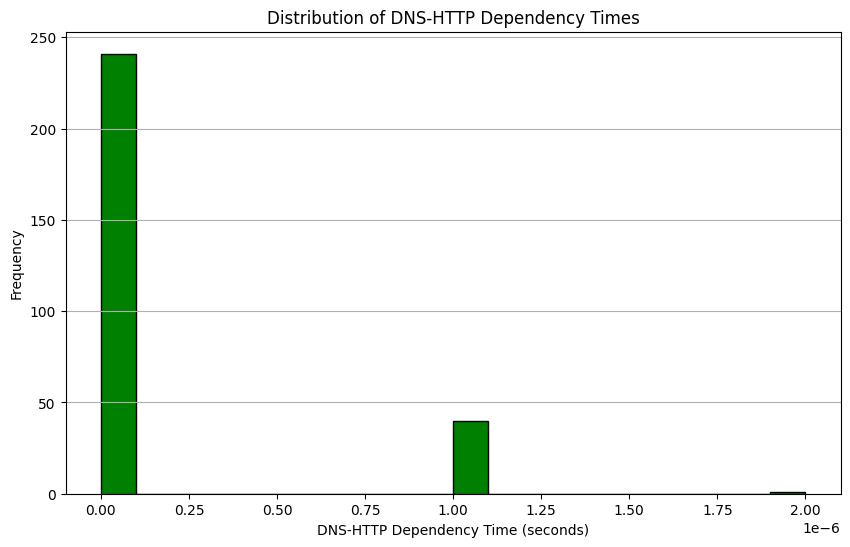

In [27]:
# Visualization 3: Histogram of DNS-HTTP Dependency Times
plt.figure(figsize=(10, 6))
http_requests['dns_http_dependency'].dropna().plot(kind='hist', bins=20, color='green', edgecolor='black')
plt.xlabel("DNS-HTTP Dependency Time (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of DNS-HTTP Dependency Times")
plt.grid(axis='y')
plt.show()

***Histogram of DNS-HTTP Dependency Times:***
* This histogram highlights the frequency of various DNS-HTTP dependency times, showing how often different delays occur, which can reveal common bottlenecks.

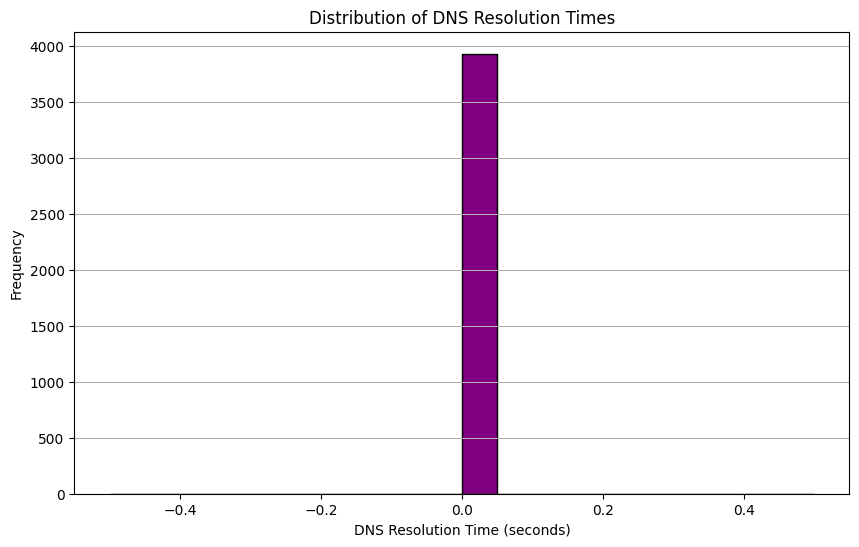

In [28]:
# Visualization 4: DNS Resolution Time Histogram
plt.figure(figsize=(10, 6))
dns_pairs['resolution_time'].plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.xlabel("DNS Resolution Time (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of DNS Resolution Times")
plt.grid(axis='y')
plt.show()

***Histogram of DNS Resolution Times:***
* This histogram displays the distribution of DNS resolution times, offering insights into typical DNS performance and the frequency of longer resolution times that could impact page load efficiency.

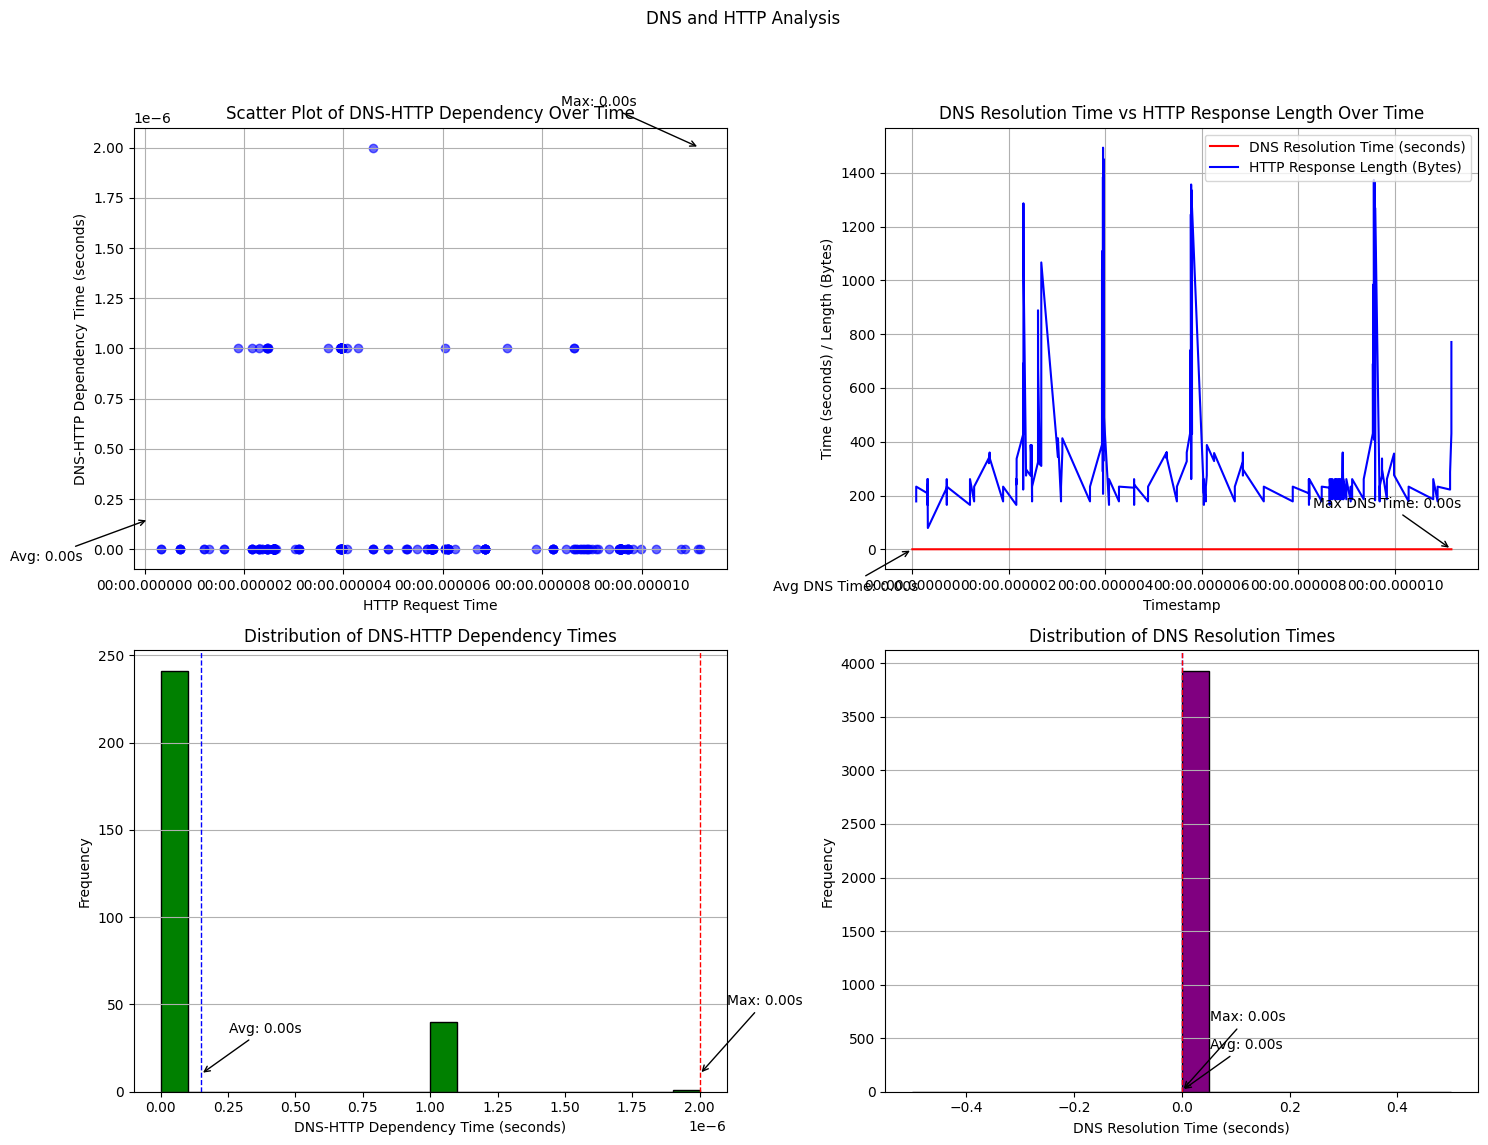

In [29]:
# Create subplots for all graphs with annotations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('DNS and HTTP Analysis')

# Scatter Plot of DNS-HTTP Dependency Over Time
axes[0, 0].scatter(http_requests['Time'], http_requests['dns_http_dependency'], alpha=0.6, color='blue')
axes[0, 0].set_xlabel('HTTP Request Time')
axes[0, 0].set_ylabel('DNS-HTTP Dependency Time (seconds)')
axes[0, 0].set_title('Scatter Plot of DNS-HTTP Dependency Over Time')
axes[0, 0].grid(True)

# Annotate max and average dependency times
max_dependency = http_requests['dns_http_dependency'].max()
avg_dependency = http_requests['dns_http_dependency'].mean()
axes[0, 0].annotate(f'Max: {max_dependency:.2f}s', xy=(http_requests['Time'].iloc[-1], max_dependency), 
                    xytext=(-100, 30), textcoords='offset points', arrowprops=dict(arrowstyle="->"))
axes[0, 0].annotate(f'Avg: {avg_dependency:.2f}s', xy=(http_requests['Time'].iloc[0], avg_dependency), 
                    xytext=(-100, -30), textcoords='offset points', arrowprops=dict(arrowstyle="->"))


# Line Plot of DNS Resolution Times and HTTP Response Length
axes[0, 1].plot(dns_pairs['Time_query'], dns_pairs['resolution_time'], label='DNS Resolution Time (seconds)', color='red')
axes[0, 1].plot(http_df['Time'], http_df['Length'], label='HTTP Response Length (Bytes)', color='blue')
axes[0, 1].set_xlabel("Timestamp")
axes[0, 1].set_ylabel("Time (seconds) / Length (Bytes)")
axes[0, 1].legend()
axes[0, 1].set_title("DNS Resolution Time vs HTTP Response Length Over Time")
axes[0, 1].grid()

# Annotate max and average DNS resolution times
max_dns_time = dns_pairs['resolution_time'].max()
avg_dns_time = dns_pairs['resolution_time'].mean()
axes[0, 1].annotate(f'Max DNS Time: {max_dns_time:.2f}s', xy=(dns_pairs['Time_query'].iloc[-1], max_dns_time), 
                    xytext=(-100, 30), textcoords='offset points', arrowprops=dict(arrowstyle="->"))
axes[0, 1].annotate(f'Avg DNS Time: {avg_dns_time:.2f}s', xy=(dns_pairs['Time_query'].iloc[0], avg_dns_time), 
                    xytext=(-100, -30), textcoords='offset points', arrowprops=dict(arrowstyle="->"))


# Histogram of DNS-HTTP Dependency Times
http_requests['dns_http_dependency'].dropna().plot(kind='hist', bins=20, color='green', edgecolor='black', ax=axes[1, 0])
axes[1, 0].set_xlabel("DNS-HTTP Dependency Time (seconds)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Distribution of DNS-HTTP Dependency Times")
axes[1, 0].grid(axis='y')

# Annotate max and average dependency times in histogram
axes[1, 0].axvline(avg_dependency, color='blue', linestyle='dashed', linewidth=1)
axes[1, 0].annotate(f'Avg: {avg_dependency:.2f}s', xy=(avg_dependency, 10), xytext=(20, 30), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->"))
axes[1, 0].axvline(max_dependency, color='red', linestyle='dashed', linewidth=1)
axes[1, 0].annotate(f'Max: {max_dependency:.2f}s', xy=(max_dependency, 10), xytext=(20, 50), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->"))

# Histogram of DNS Resolution Times
dns_pairs['resolution_time'].dropna().plot(kind='hist', bins=20, color='purple', edgecolor='black', ax=axes[1, 1])
axes[1, 1].set_xlabel("DNS Resolution Time (seconds)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Distribution of DNS Resolution Times")
axes[1, 1].grid(axis='y')

# Annotate max and average DNS resolution times in histogram
axes[1, 1].axvline(avg_dns_time, color='blue', linestyle='dashed', linewidth=1)
axes[1, 1].annotate(f'Avg: {avg_dns_time:.2f}s', xy=(avg_dns_time, 10), xytext=(20, 30), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->"))
axes[1, 1].axvline(max_dns_time, color='red', linestyle='dashed', linewidth=1)
axes[1, 1].annotate(f'Max: {max_dns_time:.2f}s', xy=(max_dns_time, 10), xytext=(20, 50), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->"))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include the main title
plt.show()

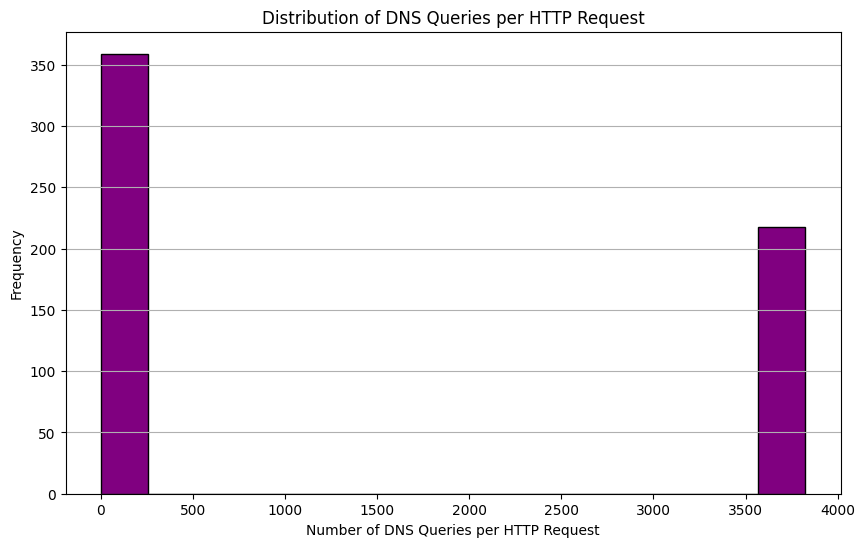

In [30]:
# Count DNS queries per unique HTTP request (using destination IP as identifier)
dns_query_count = dns_pairs.groupby('Destination').size().reset_index(name='dns_query_count')

# Merge with HTTP requests to show DNS query count per HTTP request destination
http_requests = http_requests.merge(dns_query_count, how='left', on='Destination')
http_requests['dns_query_count'] = http_requests['dns_query_count'].fillna(0)

# Plot: Histogram of DNS Queries per HTTP Request
plt.figure(figsize=(10, 6))
http_requests['dns_query_count'].plot(kind='hist', bins=15, color='purple', edgecolor='black')
plt.xlabel("Number of DNS Queries per HTTP Request")
plt.ylabel("Frequency")
plt.title("Distribution of DNS Queries per HTTP Request")
plt.grid(axis='y')
plt.show()


***Number of DNS Queries per HTTP Request***
* This metric highlights cases where multiple DNS queries precede a single HTTP request, potentially indicating inefficiencies or caching issues.

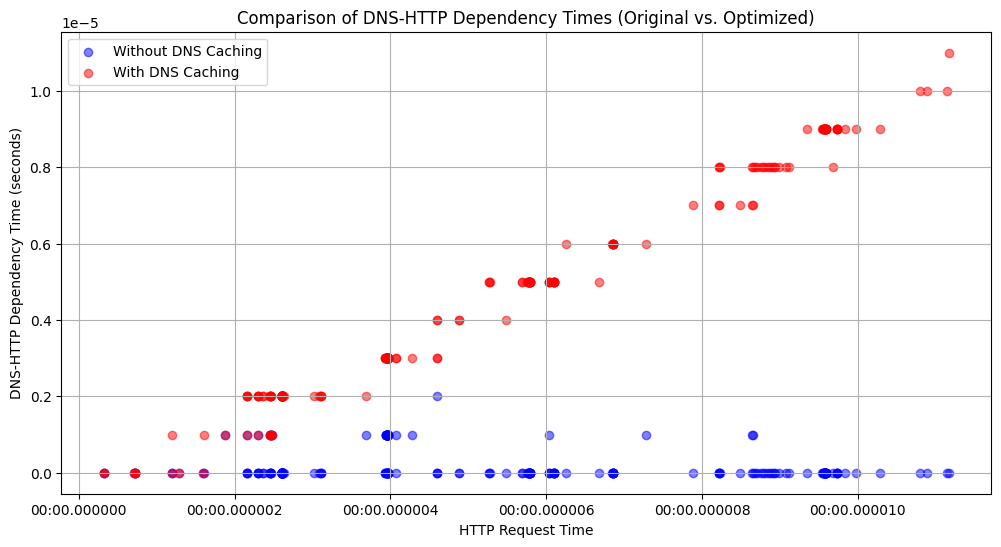

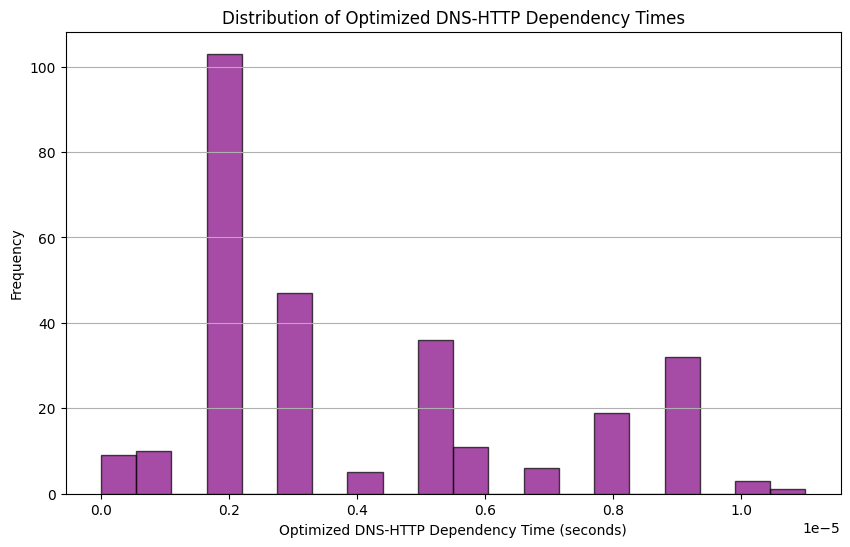

In [31]:
# Scatter plot of original vs. optimized DNS-HTTP dependency times
plt.figure(figsize=(12, 6))
plt.scatter(http_requests['Time'], http_requests['dns_http_dependency'], alpha=0.5, color='blue', label="Without DNS Caching")
plt.scatter(http_requests['Time'], http_requests['dns_http_dependency_cached'], alpha=0.5, color='red', label="With DNS Caching")
plt.xlabel('HTTP Request Time')
plt.ylabel('DNS-HTTP Dependency Time (seconds)')
plt.title('Comparison of DNS-HTTP Dependency Times (Original vs. Optimized)')
plt.legend()
plt.grid()
plt.show()

# Histogram of optimized DNS-HTTP dependency times
plt.figure(figsize=(10, 6))
http_requests['dns_http_dependency_cached'].dropna().plot(kind='hist', bins=20, color='purple', edgecolor='black', alpha=0.7)
plt.xlabel("Optimized DNS-HTTP Dependency Time (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Optimized DNS-HTTP Dependency Times")
plt.grid(axis='y')
plt.show()